In [27]:
%matplotlib inline
import pandas as pd
import uproot
import awkward
import matplotlib.pyplot as plt
import numpy as np
import glob
from matplotlib.colors import LogNorm
import uproot_methods
from tqdm.auto import tqdm
import time

from utils import (
    set_plotting_style, get_chunking, make_df, hist2d_dask, query_dis,
    dataframe_to_ttree, ttree_to_dataframe
)
import utils

from dask.distributed import Client
import dask.dataframe as dd
import dask.array as da
from dask import delayed
from yahist import Hist1D, Hist2D

In [28]:
set_plotting_style()

In [128]:
# cut = "pass_baseline_extra_iso"
# cut = "pass_baseline_iso"
cut = "pass_l1"
branches = ["dimuon_mass","dimuon_massCorr","dimuon_pt","logabsetaphi",
            "Muon*_dxy*","/pass_(baseline_extra_iso|baseline_iso|genmatch)/","lxy","ctau",
            "pass_l1",
            "minabsdxy",
           ]


In [129]:
lumi = 10.1
# ver = "v22"
ver = "vtest2ctau"
samples = glob.glob(f"/hadoop/cms/store/user/namin/ProjectMetis/HToZd*mzd8*ctau*mm_BABY_{ver}/")
dfs_mc = {}
for sample in samples:
    fnames = glob.glob(f"{sample}/*.root")
    df_mc = make_df(
        fnames,
        branches = list(set(branches + ["Muon1_genMatch_motherct","dimuon_mass"])-set(["dimuon_massCorr"])),
        cut = cut,
        chunksize = 400e3,
        use_dask = False,
        progress = False,
    )
    name = fnames[0].rsplit("/",2)[-2].split("params_")[1].split("_BABY")[0]
    df = df_mc[df_mc[cut]]
    nevents_in = sum(uproot.open(fname)["nevents_input"]._fVal for fname in fnames)
    xsec = 10 # in fb-1
    # Leff = N/xsec; scale1fb = 1ifb/Leff
    df["scale1fb"] = 1.0*xsec/nevents_in
    df["weight"] = 10.1*df["scale1fb"]
    df["xsec"] = xsec
    dfs_mc[name] = df
dfs_mc.keys()

dict_keys(['mzd8_ctau100mm', 'mzd8_ctau10mm', 'mzd8_ctau1mm', 'mzd8_ctau50mm'])

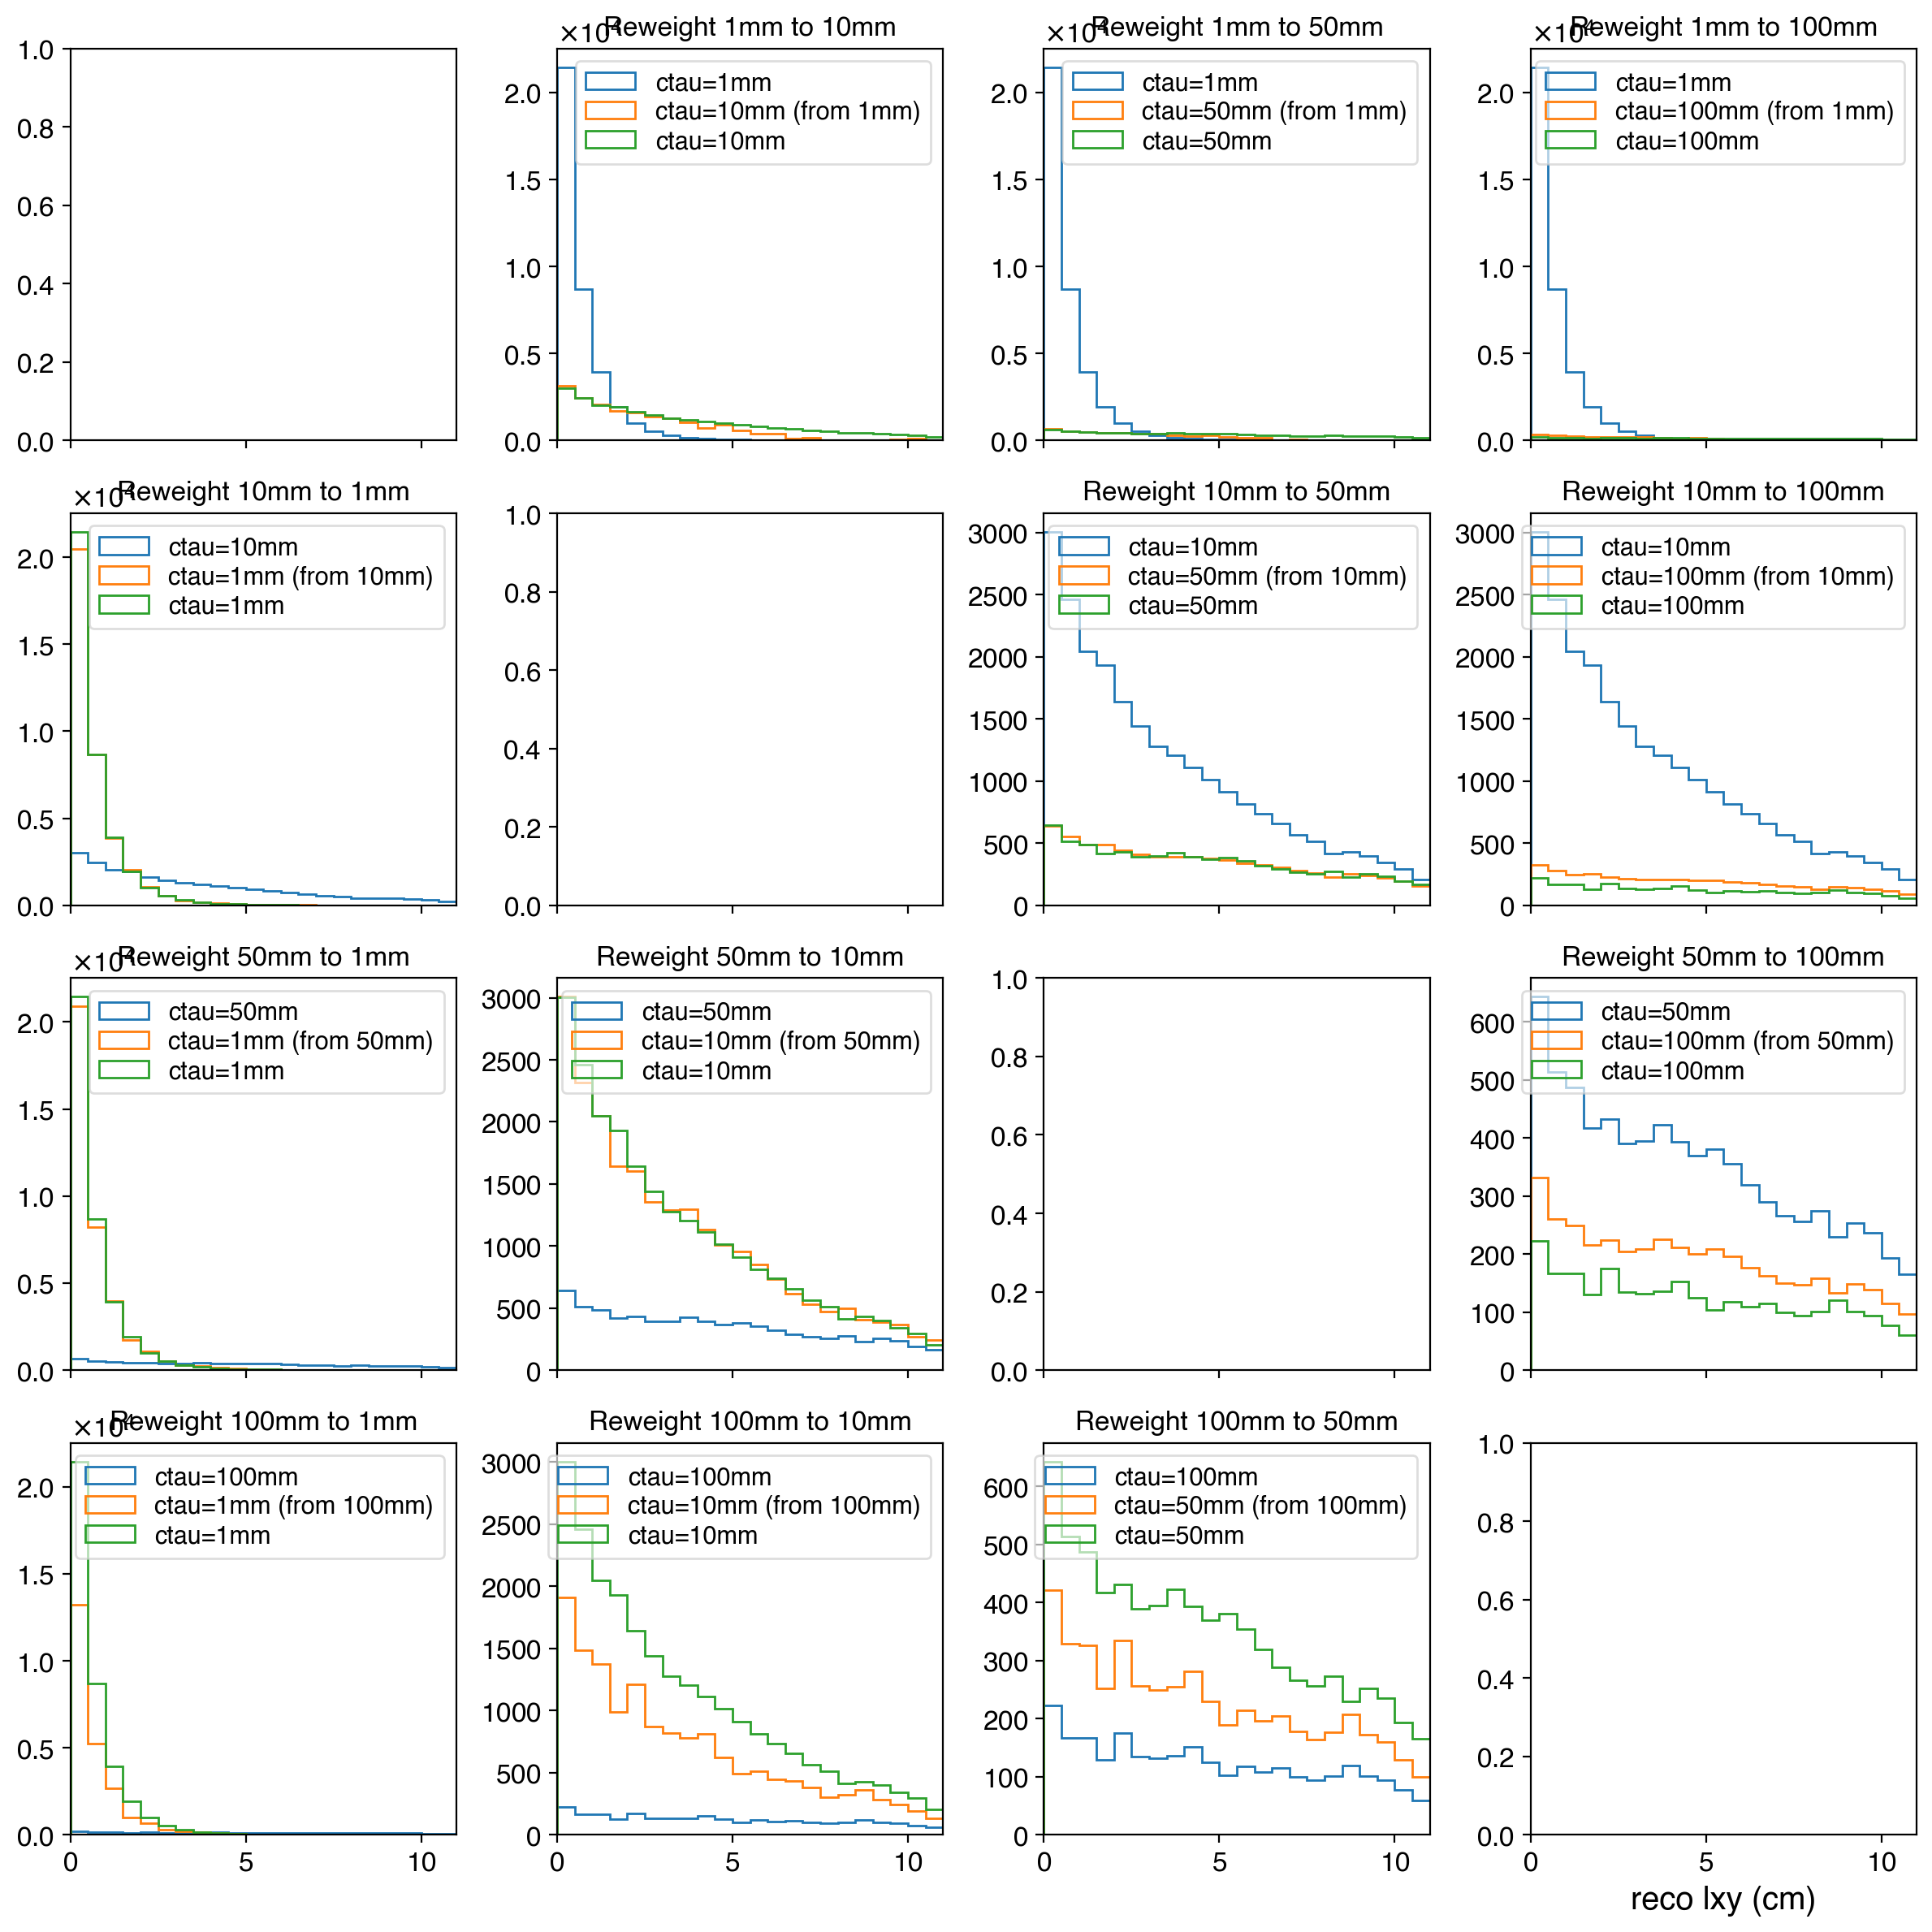

In [130]:
def plot(ax, ctau0, ctau1, normalize=False):

    bins = "22,0,11.0"

    df = dfs_mc[f"mzd8_ctau{ctau0}mm"]
    h = Hist1D(df["lxy"], bins=bins,label=f"ctau={ctau0}mm")
    if normalize: h = h.normalize()
    h.plot(ax=ax, histtype="step")
    

    df["genct"] = 10.0*df["Muon1_genMatch_motherct"] # event by event ct in mm
    w = (ctau0/ctau1) * np.exp(df["genct"]/ctau0 - df["genct"]/ctau1)
    h = Hist1D(df["lxy"], bins=bins,label=f"ctau={ctau1}mm (from {ctau0}mm)",weights=w)
    if normalize: h = h.normalize()
    h.plot(ax=ax, histtype="step")
    
    df = dfs_mc[f"mzd8_ctau{ctau1}mm"]
    h = Hist1D(df["lxy"], bins=bins,label=f"ctau={ctau1}mm")
    if normalize: h = h.normalize()
    h.plot(ax=ax, histtype="step")
    
    
    ax.set_title(f"Reweight {ctau0}mm to {ctau1}mm")
#     ax.set_xlabel("lxy (cm)")
    ax.legend()

ctaus = [1,10,50,100]
fig, axs = plt.subplots(len(ctaus),len(ctaus), figsize=(12,12), sharex=True)

def ctaupairs():
    for ctau0 in ctaus:
        for ctau1 in ctaus:
            yield ctau0, ctau1
for ax,(ctau0,ctau1) in zip(axs.flat,ctaupairs()):
    if ctau0 == ctau1: 
#         ax.set_visible(False)
        continue
    plot(ax, ctau0, ctau1)
ax.set_xlabel("reco lxy (cm)")
fig.set_tight_layout(True)
# fig.savefig("reweight_ctau.pdf")

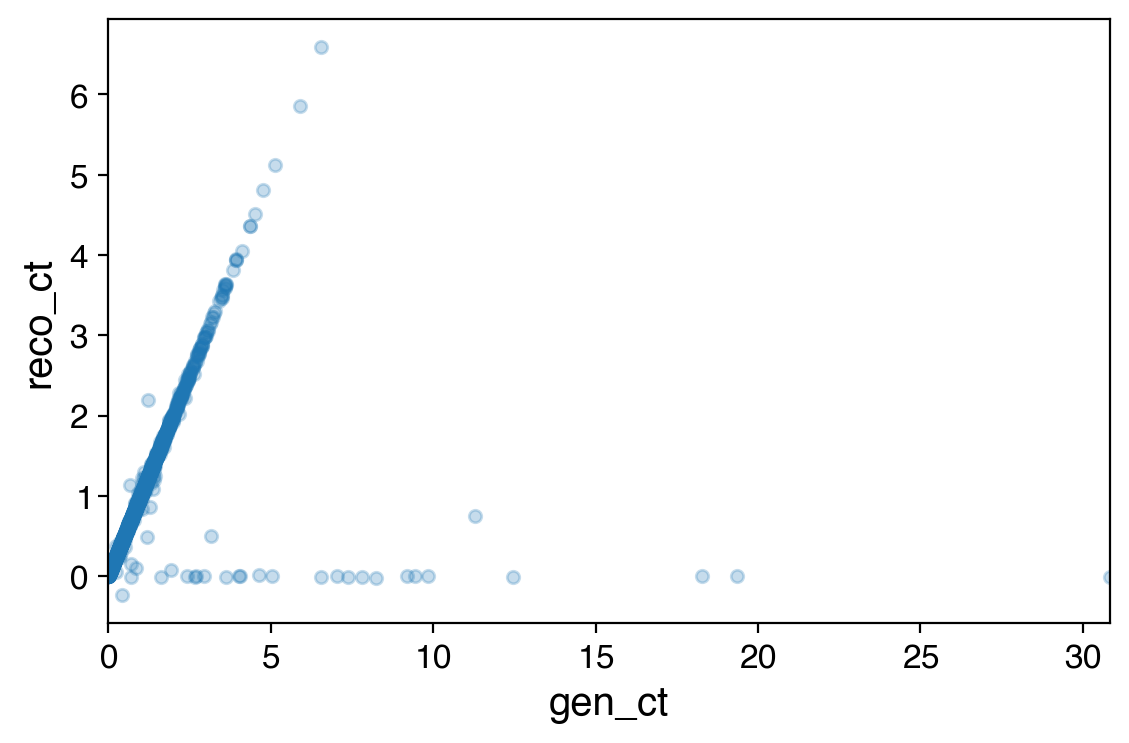

In [131]:

df = dfs_mc[f"mzd8_ctau100mm"]
# df["Muon1_genMatch_motherct"]
# df["ctau"]

df.rename({"Muon1_genMatch_motherct":"gen_ct","ctau":"reco_ct"},axis=1).plot.scatter(x="gen_ct",y="reco_ct", alpha=0.25)

In [132]:
# def plot_weights(ax, ctau0, ctau1, normalize=True):


#     df = dfs_mc[f"mzd8_ctau{ctau0}mm"]
#     df["genct"] = 10.0*df["Muon1_genMatch_motherct"] # event by event ct in mm
#     w = (ctau0/ctau1) * np.exp(df["genct"]/ctau0 - df["genct"]/ctau1)
#     bins = np.linspace(0,w.max(), 100)
#     h = Hist1D(w, bins=bins).normalize()
#     h.plot(ax=ax, histtype="step")
#     ax.set_title(f"Weights for {ctau0}mm to {ctau1}mm")
#     ax.set_yscale("log")

# ctaus = [1,10,50,100]
# fig, axs = plt.subplots(len(ctaus),len(ctaus), figsize=(12,12))

# def ctaupairs():
#     for ctau0 in ctaus:
#         for ctau1 in ctaus:
#             yield ctau0, ctau1
# for ax,(ctau0,ctau1) in zip(axs.flat,ctaupairs()):
#     if ctau0 == ctau1: 
# #         ax.set_visible(False)
#         continue
#     plot_weights(ax, ctau0, ctau1)
# ax.set_xlabel("weight")
# # fig.set_tight_layout(True)

In [133]:
mass = 8
ctau = 100
dfc = pd.read_csv(f"../batch/junk/ctaurw_mass{mass}_ctau{ctau}.csv")
dfc.columns.values[0] = "mass"
dfc

,mass,ctau,gen_ct,gen_dimuon_pt,gen_dimuon_mass,gen_lxy,reco_ct,reco_dimuon_pt,reco_dimuon_mass,reco_lxy,reco_l1
0,8,100,9.33575,58.2163,8,67.9367,-1.0,-1.0,-1.0,-1.0,0
1,8,100,3.87617,59.5516,8,28.8540,-1.0,-1.0,-1.0,-1.0,0
2,8,100,2.42643,63.1470,8,19.1527,-1.0,-1.0,-1.0,-1.0,0
3,8,100,2.46008,47.0264,8,14.4611,-1.0,-1.0,-1.0,-1.0,0
4,8,100,6.02783,25.6457,8,19.3235,-1.0,-1.0,-1.0,-1.0,0
...,...,...,...,...,...,...,...,...,...,...,...
87322,8,100,11.78860,43.9869,8,64.8182,-1.0,-1.0,-1.0,-1.0,0
87323,8,100,3.49583,38.8620,8,16.9819,-1.0,-1.0,-1.0,-1.0,0
87324,8,100,17.22410,18.0343,8,38.8280,-1.0,-1.0,-1.0,-1.0,0
87325,8,100,14.37100,34.2142,8,61.4618,-1.0,-1.0,-1.0,-1.0,0


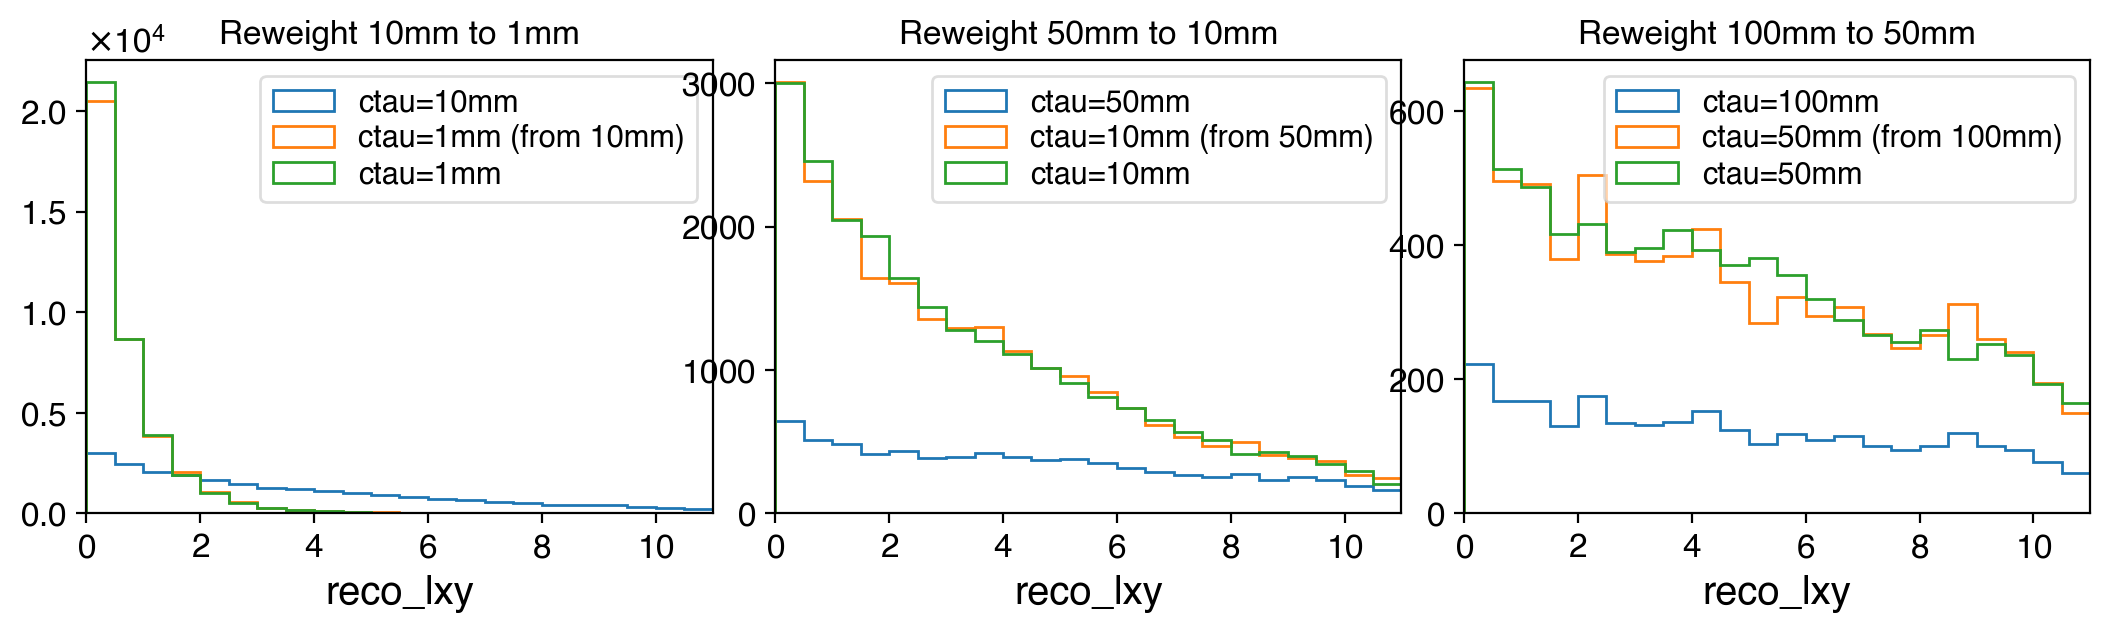

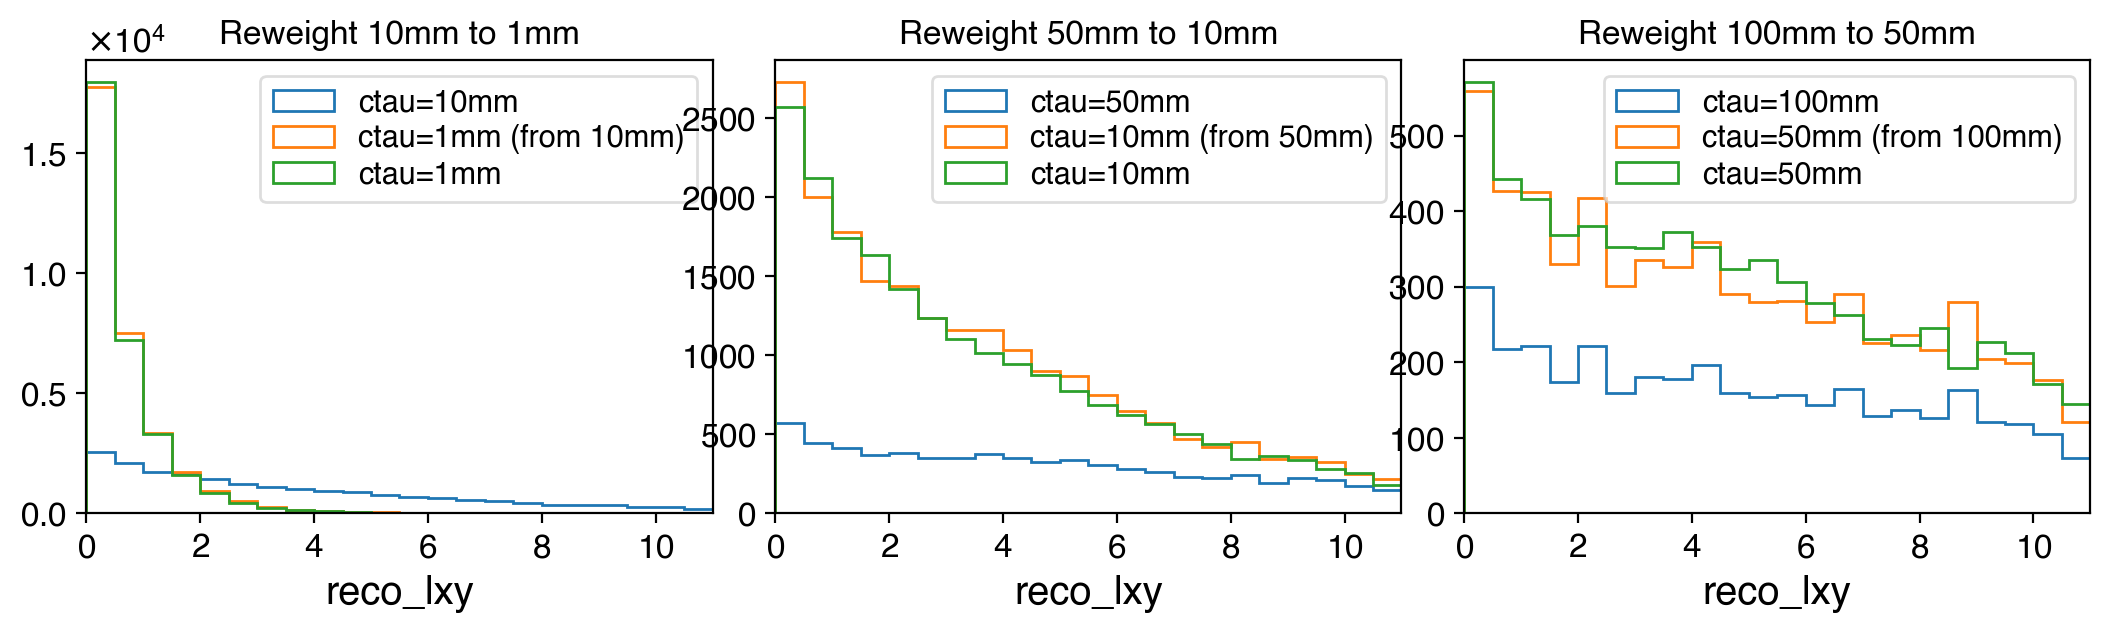

In [157]:
def plot(ax, ctau0, ctau1, baby, linestyle="-"):
    
    xvar = "reco_lxy"

    if ctau0 <= 10 and ctau1 <= 10:
        bins = "40,0,5"
    else:
        bins = "40,0,20.0"
    if xvar == "reco_lxy":
        bins = "22,0,11"

    wextra = 1.
    if baby:
        df0 = dfs_mc[f"mzd8_ctau{ctau0}mm"].rename({"Muon1_genMatch_motherct":"gen_ct", "lxy":"reco_lxy"},axis=1)
        df1 = dfs_mc[f"mzd8_ctau{ctau1}mm"].rename({"Muon1_genMatch_motherct":"gen_ct", "lxy":"reco_lxy"},axis=1)
        wextra *= df0["weight"].mean()/df1["weight"].mean() # weight from nevent difference
    else:
        df0 = pd.read_csv(f"../batch/junk/ctaurw_mass{mass}_ctau{ctau0}.csv")
        df1 = pd.read_csv(f"../batch/junk/ctaurw_mass{mass}_ctau{ctau1}.csv")
        df1.columns.values[0] = "mass"
        df0.columns.values[0] = "mass"
        n0 = len(df0)
        n1 = len(df1)
        wextra = n0/n1 # weight from nevent difference
        df0 = df0.query("(reco_lxy >= 0) and reco_l1==1")
        df1 = df1.query("(reco_lxy >= 0) and reco_l1==1")
    
    h = Hist1D(df0[xvar], bins=bins,label=f"ctau={ctau0}mm")
    h.plot(ax=ax, histtype="step", linestyle=linestyle, color="C0")

    w = wextra * (ctau0/ctau1) * np.exp(df0.eval("10*gen_ct/@ctau0 - 10*gen_ct/@ctau1")) # cm to mm
    h = Hist1D(df0[xvar], bins=bins,label=f"ctau={ctau1}mm (from {ctau0}mm)",weights=w)
    h.plot(ax=ax, histtype="step", linestyle=linestyle, color="C1")

    h = Hist1D(df1[xvar], bins=bins,label=f"ctau={ctau1}mm")
    h.plot(ax=ax, histtype="step", linestyle=linestyle, color="C2")
    
    ax.set_title(f"Reweight {ctau0}mm to {ctau1}mm")
    ax.legend()
    ax.set_xlabel(xvar)

fig, axs = plt.subplots(1,3, figsize=(12,3))
baby = True
plot(axs[0], 10, 1, baby=baby)
plot(axs[1], 50, 10, baby=baby)
plot(axs[2], 100, 50, baby=baby)

fig, axs = plt.subplots(1,3, figsize=(12,3))
baby = False
plot(axs[0], 10, 1, baby=baby)
plot(axs[1], 50, 10, baby=baby)
plot(axs[2], 100, 50, baby=baby)

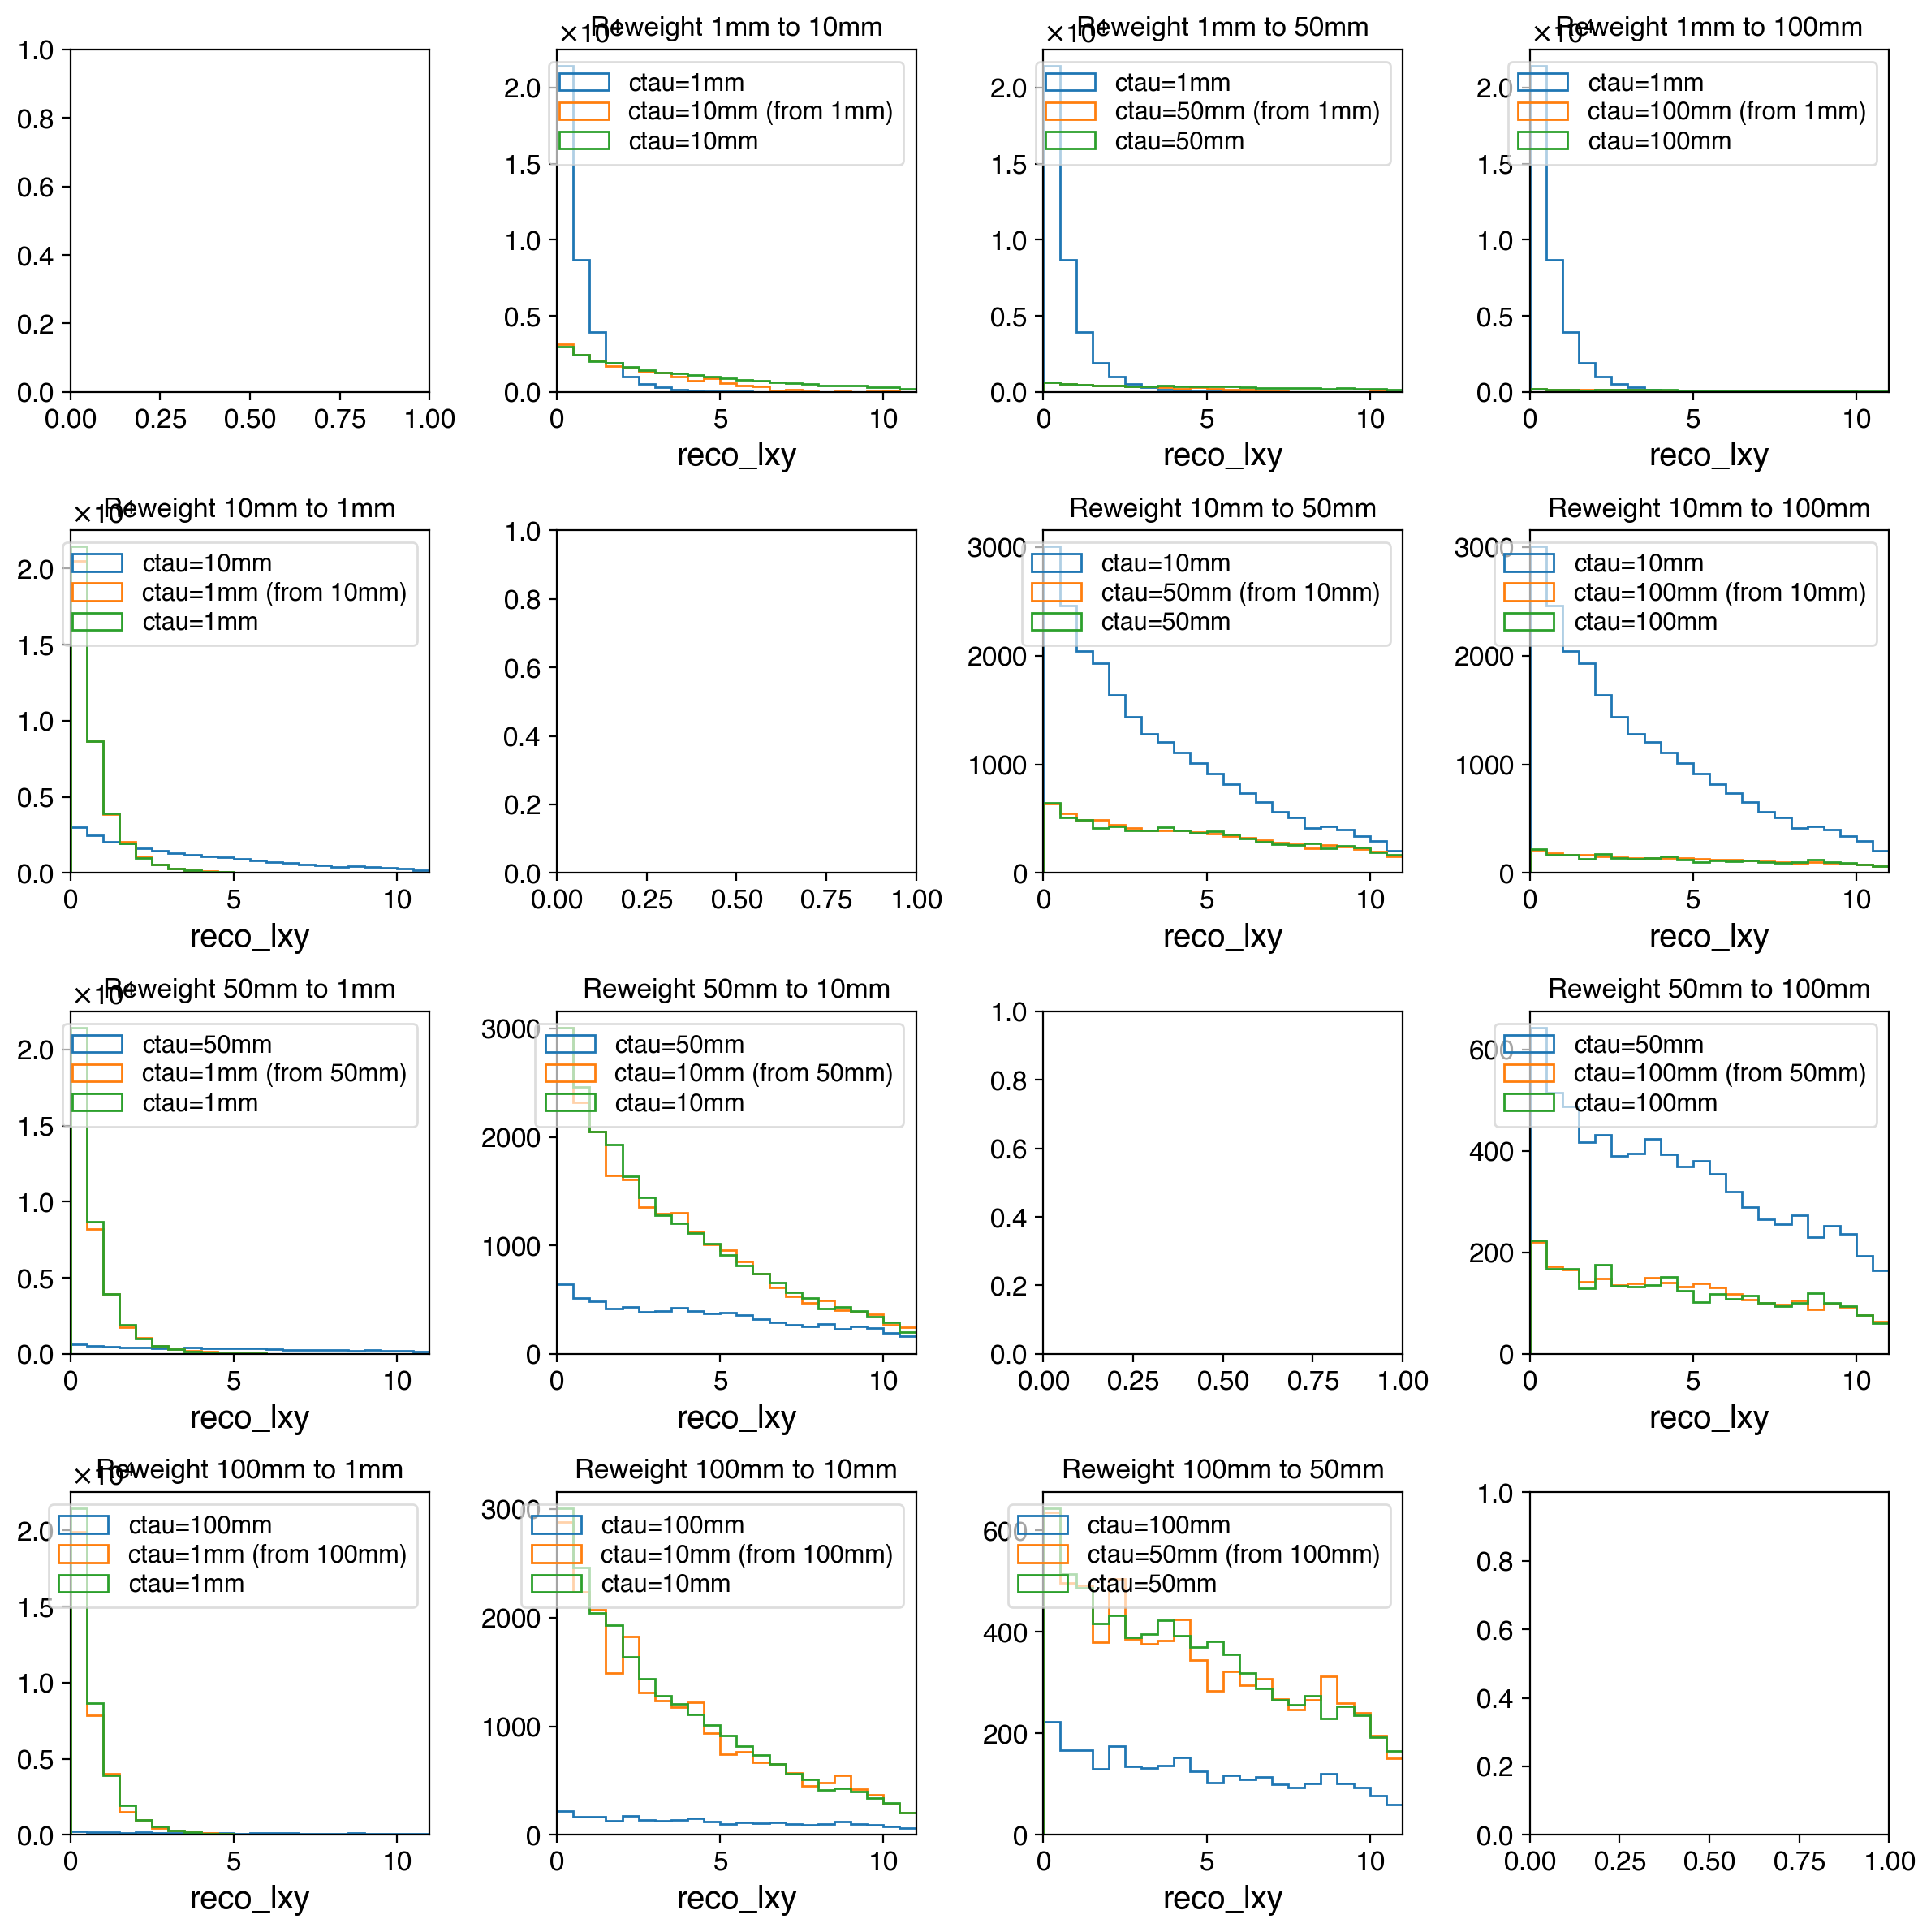

In [158]:
ctaus = [1,10,50,100]
fig, axs = plt.subplots(len(ctaus),len(ctaus), figsize=(12,12))

def ctaupairs():
    for ctau0 in ctaus:
        for ctau1 in ctaus:
            yield ctau0, ctau1
for ax,(ctau0,ctau1) in zip(axs.flat,ctaupairs()):
    if ctau0 == ctau1: 
#         ax.set_visible(False)
        continue
#     plot(ax, ctau0, ctau1, baby=False)
    plot(ax, ctau0, ctau1, baby=True)
fig.set_tight_layout(True)